# SARIMA Tahmini

## 01 - Arka Plan

Bu zorlukta amacımız, zaman serisi analizinin temel kavramlarını tek boyutlu verilere (tarihe bağlı satışlar) uygulamaktır.

Bu zorlukta aşağıdaki adımları takip edeceğiz:
1. verileri yükle ve görselleştir;
2. modellerimizi eğit ve tahminler yap;
3. seriyi modellemek ve tahmin edebilmek için ekonometrik bir yaklaşım kullan;
4. bu modeli hacklemek için Makine Öğrenmesi kullan.

Veri seti [Machine Learning Mastery](https://github.com/jbrownlee/) tarafından sağlanmıştır. İndirmek için aşağıdaki satırı çalıştırın!

In [1]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv > data/monthly_champagne_sales.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
0     0   5142      0 --:--:-- --:--:-- --:--:--  5131 --:--:-- --:--:--     0


## 02 - Veri Yükleme
Meydan okumanın zaman serisini yükleyerek başlayalım

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/monthly_champagne_sales.csv")
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


👉 DataFrame'in "Month" sütununu `Datetime` nesnelerine dönüştürün ve şu şekilde görünmesi için indeks olarak ayarlayın:
<br>

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/monthly_champagne_sales_objective.png" width=180>

In [3]:
df.index = pd.to_datetime(df.index)
df.head()

,Month,Sales
1970-01-01 00:00:00.000000000,1964-01,2815
1970-01-01 00:00:00.000000001,1964-02,2672
1970-01-01 00:00:00.000000002,1964-03,2755
1970-01-01 00:00:00.000000003,1964-04,2721
1970-01-01 00:00:00.000000004,1964-05,2946


In [4]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

### Alternatif - Pandas'ın İşi Yapmasına İzin Ver

In [5]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## 04 - Veriyi Görselleştir ve Yorumla

Aferin, bu yeniden indeksleme sayesinde artık "Sales" (y-ekseni) değerlerini zamanın (x-ekseni) bir fonksiyonu olarak kolayca çizebilmelisiniz

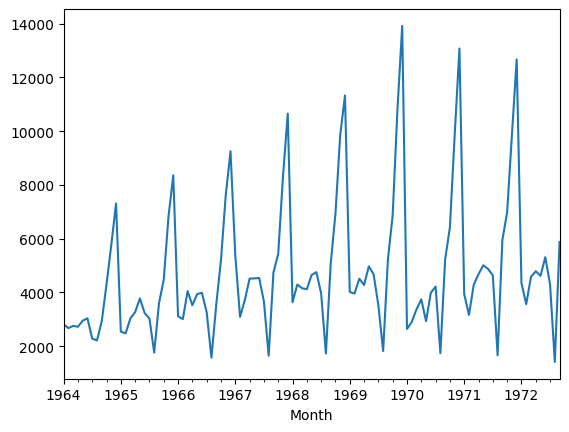

In [6]:
df["Sales"].plot();

Kodunuz doğruysa, bu zaman serisinin (TS) şu özelliklere sahip olduğunu görebilmelisiniz:
- Durağan değil (ortalama ve varyans sabit değil).
- Güçlü mevsimsellik sergiliyor.
- Bir trend var gibi görünüyor.

Verilerin **trend**, **mevsimsellik** ve **gürültü** arasındaki ayrışımını görelim. Bunun için statsmodels'ın [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) fonksiyonunu kullanmalısınız. Dokümanları okuyun ve bu fonksiyonun ne yaptığını ve nasıl kullanıldığını anladığınızdan emin olun, ardından:
1. "Sales"i "additive" model ile çizin
2. "Sales"i "multiplicative" model ile çizin

Profesyonel ipuçları: çift çizim sorunlarını önlemek için statsmodels plot metot çağrılarınızı noktalı virgülle (`;`) bitirin!

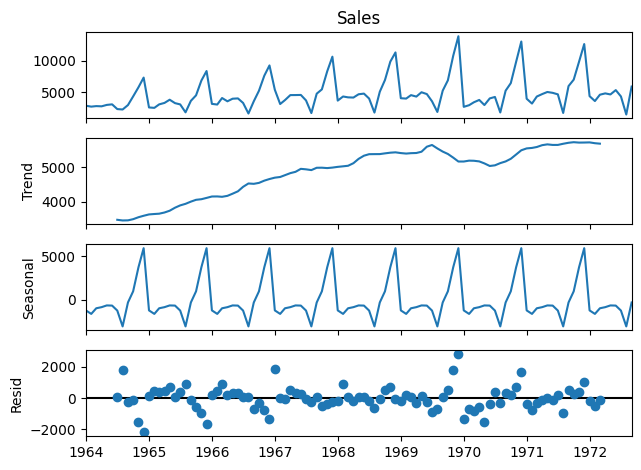

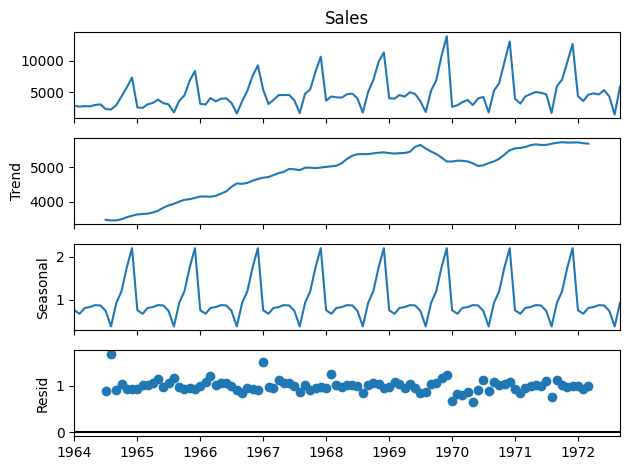

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive decomposition
decomp_add = seasonal_decompose(df["Sales"], model="additive", period=12)
decomp_add.plot();

# Multiplicative decomposition
decomp_mul = seasonal_decompose(df["Sales"], model="multiplicative", period=12)
decomp_mul.plot();

👉 Seçtiğiniz ayrışımı kullanarak bu zaman serisini mevsimsellikten arındırın

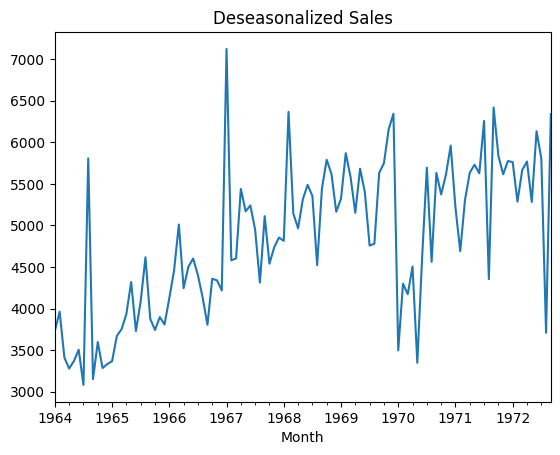

In [8]:
df_deseasonalized = df["Sales"] / decomp_mul.seasonal
df_deseasonalized.plot(title="Deseasonalized Sales");

☝️ Bu zaman serisinin "mevsimsellikten arındırılmış" versiyonuna bir ARIMA modeli uydurabilir ve tahminimizden sonra tekrar birleştirebiliriz. Ancak bu meydan okumada, orijinal zaman serisine _doğrudan_ uydurmak için SARIMA modellerini kullanacağız!

## 05 - Veriyi Böl (eğitim/test)


Zaman serileri için test setinde bulunacak noktaları rastgele örnekleyemeyiz. Test setinin "zaman-dışı" olması gerekir, yani test setinin kesinlikle geleceğinde olmalıdır. Bu egzersiz için eğitim için 1970'e kadar olan verileri kullanacağız ve bundan sonraki her şey test için kullanılacak.

👉 `df_train` ve `df_test` oluşturun, DataFrame'i eğitim için 1970 öncesinde ve test için sonrasında (veya eşit) bölerek

In [9]:
df_train = df.loc[df.index < "1970-01-01", "Sales"]
df_test  = df.loc[df.index >= "1970-01-01", "Sales"]

df_train.tail(), df_test.head()

(Month
 1969-08-01     1821
 1969-09-01     5222
 1969-10-01     6872
 1969-11-01    10803
 1969-12-01    13916
 Name: Sales, dtype: int64,
 Month
 1970-01-01    2639
 1970-02-01    2899
 1970-03-01    3370
 1970-04-01    3740
 1970-05-01    2927
 Name: Sales, dtype: int64)

In [10]:
print(df_train.index.min(), "→", df_train.index.max(), "| n =", len(df_train))
print(df_test.index.min(),  "→", df_test.index.max(),  "| n =", len(df_test))

1964-01-01 00:00:00 → 1969-12-01 00:00:00 | n = 72
1970-01-01 00:00:00 → 1972-09-01 00:00:00 | n = 33


## 06 - SARIMA
Veriyi SARIMA modeli (Seasonal Auto-Regressive Integrated Moving Average - Mevsimsel Oto-Regresif Entegre Hareketli Ortalama) kullanarak analiz edeceğiz.


Yapmamız gerekenler:
- zaman serisini nasıl durağanlaştıracağımızı bul (SARIMA'daki I)
- oto-regresif (AR) kısmını bul
- hareketli ortalama (MA) kısmını bul
- mevsimselliği (S) bul

### Adım 1: Durağanlığı Kontrol Et

Bir zaman serisinin trend veya mevsimsellik bileşeni varsa, tahmin için ARIMA kullanabilmek için önce durağan hale getirilmelidir.

Yukarıdaki grafiğe bir bakış, zaman serisinin durağan olmadığına sizi ikna etmeye yeterli olmalıdır.

[`Augmented Dick Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) ve özellikle p-değerini kullanarak `df["Sales"]`ın durağanlığını tekrar kontrol edin

In [11]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["Sales"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for k, v in adf_result[4].items():
    print(f"   {k}: {v}")

ADF Statistic: -1.8335930563276166
p-value: 0.36391577166024813
Critical Values:
   1%: -3.502704609582561
   5%: -2.8931578098779522
   10%: -2.583636712914788


Durağanlıkta %95 güvene sahip olmak için p-değeri 0.05'ten küçük olmalıdır.

Eğer p-değeri 0.05'ten büyükse, null hipotezi reddedemeyiz (null hipotez = "süreç durağan değildir").

İdeal olarak, p 0.05'ten *çok* küçük olmalıdır.

Durağanlığı aramanın başka bir yolu otokorelasyon fonksiyonuna (ACF) bakmaktır.

Zaman serisinin ACF'sini çizin. Lag 12'de büyük bir pik görmelisiniz, bu güçlü yıllık mevsimselliği gösterir.

<Figure size 1000x400 with 0 Axes>

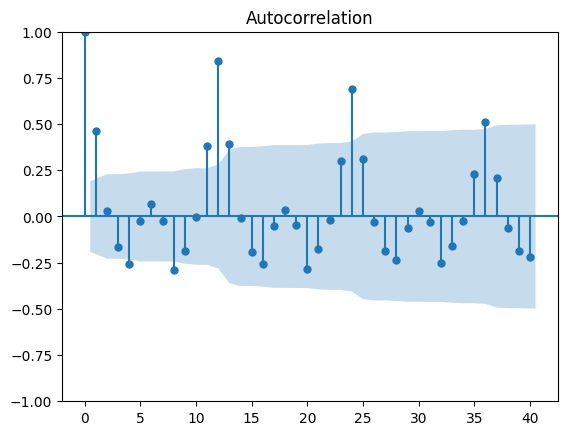

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plot_acf(df["Sales"], lags=40)
plt.show()

### Adım 2 - Mevsimsel Farklaştırma (D)

12 aylık periyodla güçlü bir mevsimselliğimiz var.

Zaman serisi üzerinde **lag 12'nin mevsimsel farklaştırmasını** yapın, farklaştırılmış veriyi çizin ve ACF grafiğini (+ADF testi) tekrar kontrol edin.

NaN'ları düşürmeyi unutmayın.

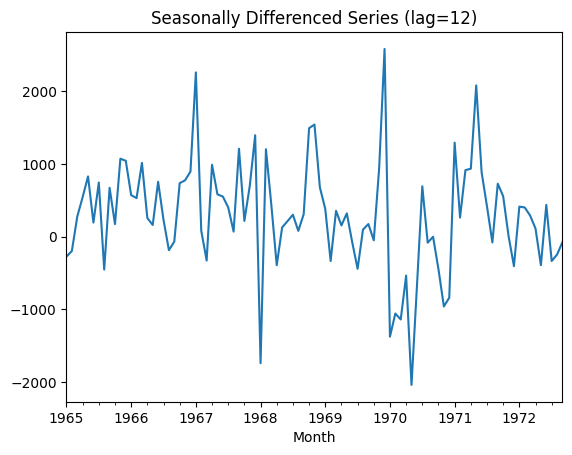

<Figure size 1000x400 with 0 Axes>

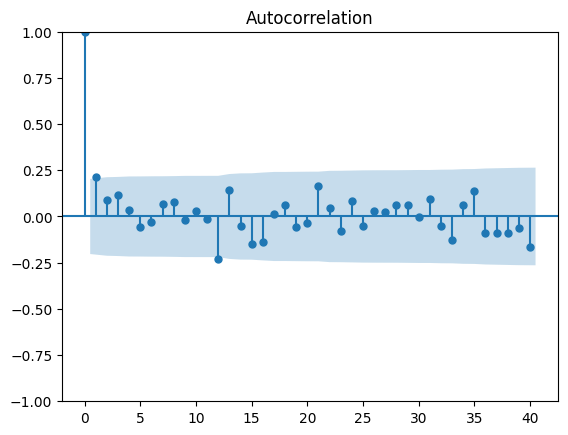

ADF Statistic: -7.626619157213164
p-value: 2.060579696813685e-11
Critical Values:
   1%: -3.503514579651927
   5%: -2.893507960466837
   10%: -2.583823615311909


In [13]:
# Mevsimsel fark (lag=12)
seasonal_diff = df["Sales"].diff(12).dropna()

# Zaman serisini çiz
seasonal_diff.plot(title="Seasonally Differenced Series (lag=12)");

# ACF
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plot_acf(seasonal_diff, lags=40)
plt.show()

# ADF testi
from statsmodels.tsa.stattools import adfuller

adf_seasonal = adfuller(seasonal_diff)

print("ADF Statistic:", adf_seasonal[0])
print("p-value:", adf_seasonal[1])
print("Critical Values:")
for k, v in adf_seasonal[4].items():
    print(f"   {k}: {v}")

☝️ TS'yi durağanlaştırmak için tek bir mevsimsel farklaştırma yeterli görünüyor.
SARIMA(p,d,q, P,D,Q,m) için D=1 (1 mevsimsel fark) ve m=12 (mevsimsellik = 12)

### Adım 3 - Farklaştırma (d)

Zaman serisi hala durağan değilse, *farklaştırma* yoluyla durağanlaştırılması gerekir. Bu, her değer ile bir önceki arasındaki farkı almak (*birinci fark*) anlamına gelir.

Mevsimselliği çıkardıktan sonra daha fazla farklaştırmaya ihtiyacımız var mı?

diff(12) seriniz üzerinde ek bir birinci derece diff(1) çalıştırdıktan sonra ACF ve ADF'yi kontrol edin.

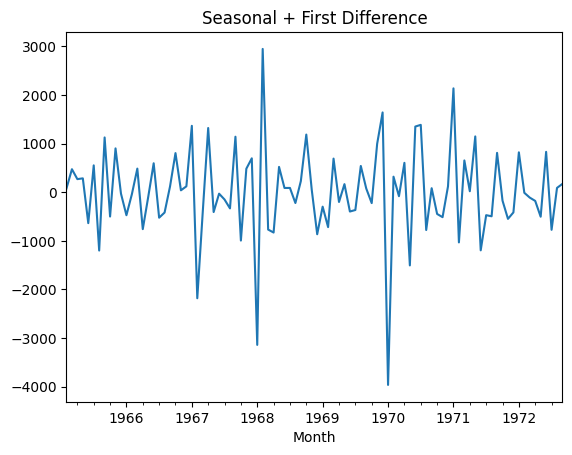

<Figure size 1000x400 with 0 Axes>

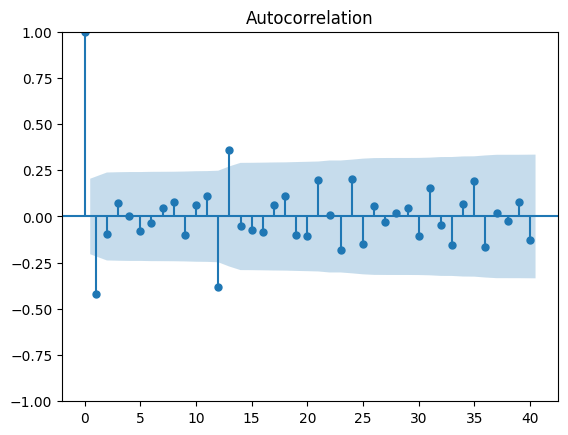

ADF Statistic: -4.427713497307502
p-value: 0.00026504628492935025
Critical Values:
   1%: -3.5148692050781247
   5%: -2.8984085156250003
   10%: -2.58643890625


In [14]:
# Ek birinci derece fark
double_diff = seasonal_diff.diff(1).dropna()

# Çiz
double_diff.plot(title="Seasonal + First Difference");

# ACF
plt.figure(figsize=(10, 4))
plot_acf(double_diff, lags=40)
plt.show()

# ADF testi
adf_double = adfuller(double_diff)

print("ADF Statistic:", adf_double[0])
print("p-value:", adf_double[1])
print("Critical Values:")
for k, v in adf_double[4].items():
    print(f"   {k}: {v}")

👉 Ek farklaştırma hem p-değerini hem de ACF'yi daha kötü hale getirdi!
(d=0) ve (D=1) seçebiliriz

### Adım 4 - AR(p, P) ve MA(q, Q) Terimlerini Seç

Şimdi bir AR terimi, MA terimi veya her ikisini de dahil edip etmeyeceğinize karar vermek için ACF ve PACF grafiklerini kullanacaksınız.

- **Tamamen farklaştırılmış** serinize uygulanan otokorelasyon grafiği ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bir MA sayısı (`q`) seçmenize olanak tanır
- MA($\color{blue}{q}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{blue}{ACF}$'sinin kestiği lag sayısı


- **Tamamen farklaştırılmış** serinize uygulanan kısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) AR (`p`) seçmenize olanak tanır
- AR($\color{red}{p}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{red}{PACF}$'sinin kestiği lag sayısı

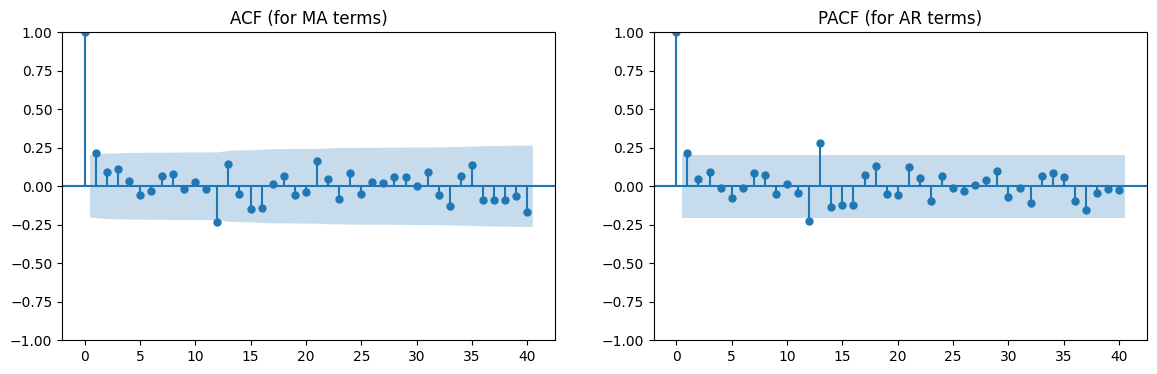

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF → MA(q) için
plot_acf(seasonal_diff, lags=40, ax=axes[0])
axes[0].set_title("ACF (for MA terms)")

# PACF → AR(p) için
plot_pacf(seasonal_diff, lags=40, ax=axes[1], method="ywm")
axes[1].set_title("PACF (for AR terms)")

plt.show()

☝️ ACF veya PACF'de anlamlı pik yok gibi görünüyor, bu yüzden büyük olasılıkla p=q=0.
SARIMA için ilk tahminimiz bu nedenle d=0, p=q=0, D=1 ve m=12.

P ve Q değerlerini nasıl bulacağız? Burada, `pdarima`'nın bizim için grid_search ile P ve Q için 1 ve 0 değerlerini denemesine izin vereceğiz.
Bu katsayıları kendiniz bulmak istiyorsanız, bazı pratik kurallar için [bunu okuyun](https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/)

👉 Eğitim seti için [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) çalıştırın. seasonal=True, m=12 ve D=1 ayarlayın. p ve q, P ve Q'yu 0'dan 2'ye kadar arayın. Ardından model.summary() ile modelin özetini yazdırın.
`njobs=-1, trace=True, error_action='ignore', suppress_warnings=True` kullanın

In [16]:
from pmdarima import auto_arima

model = auto_arima(
    df_train,
    seasonal=True,
    m=12,
    D=1,
    p=0, q=0,
    P=0, Q=0,
    max_p=2, max_q=2,
    max_P=2, max_Q=2,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    n_jobs=-1
)

model.summary()

/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'en

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.547 seconds


/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -475.126
Date:                  Wed, 21 Jan 2026   AIC                            954.252
Time:                          16:24:55   BIC                            958.441
Sample:                      01-01-1964   HQIC                           955.891
                           - 12-01-1969                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    447.0500     87.035      5.136      0.000     276.464     617.636
sigma2      4.423e+05   5.54e+04      7.979      0.000    3.34e+05    5.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                15.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             0.34
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Bulunan en iyi model `ARIMA(0,0,0)(0,1,0)[12]`!
Bu, düşünülen zaman serisinin basit "mevsimsel farklaştırma"nın ötesinde herhangi bir "oto-regresif" veya "hareketli ortalama" modelleme eklemeyi haklı çıkarmadığı anlamına gelir.

Böyle "zayıf" bir model muhtemelen sadece tespit edilen son mevsimsel desenin tekrarını ve ortalama artan trendin uzatılmasını tahmin edecektir. Kontrol edelim

👉 Aşağıdaki üç tahmini kaydetmek için `n_periods` = test setinin uzunluğu ile `model.predict` kullanın
- `central`
- `upper`
- `lower`

Bunları Pandas Series olarak kaydedin ve `y_test`inizle aynı indeks ile indeksleyin

In [17]:
# Test seti uzunluğu kadar tahmin
n_periods = len(df_test)

forecast, conf_int = model.predict(
    n_periods=n_periods,
    return_conf_int=True
)

# Pandas Series'e çevir ve test index'i ile hizala
central = pd.Series(forecast, index=df_test.index)
lower = pd.Series(conf_int[:, 0], index=df_test.index)
upper = pd.Series(conf_int[:, 1], index=df_test.index)

central.head(), lower.head(), upper.head()

/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(Month
 1970-01-01    4463.05
 1970-02-01    4404.05
 1970-03-01    4957.05
 1970-04-01    4723.05
 1970-05-01    5415.05
 dtype: float64,
 Month
 1970-01-01    3159.618374
 1970-02-01    3100.618374
 1970-03-01    3653.618374
 1970-04-01    3419.618374
 1970-05-01    4111.618374
 dtype: float64,
 Month
 1970-01-01    5766.481626
 1970-02-01    5707.481626
 1970-03-01    6260.481626
 1970-04-01    6026.481626
 1970-05-01    6718.481626
 dtype: float64)

👇 Tahminlerinizi gerçeklikle karşılaştırmak için aşağıdaki hücreyi çalıştırın

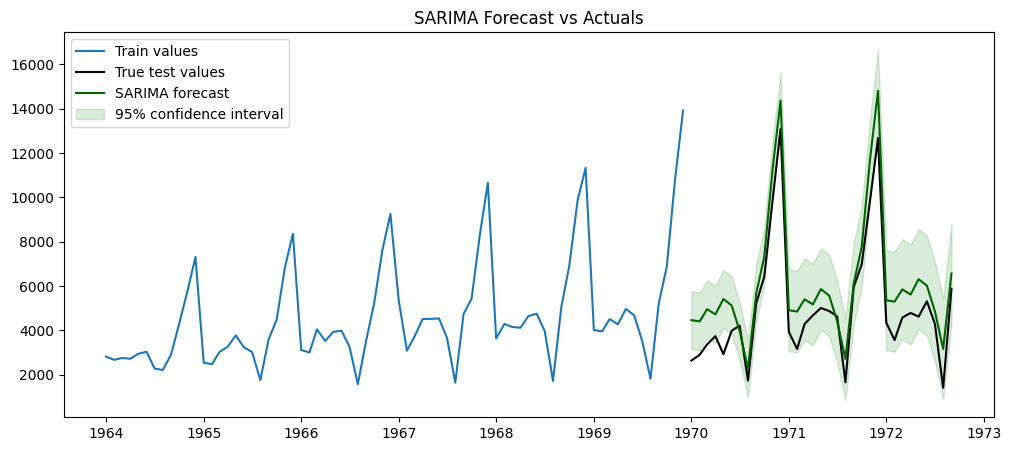

In [18]:
plt.figure(figsize=(12, 5), dpi=100)

plt.plot(df_train, label="Train values")
plt.plot(df_test, label="True test values", color="black")
plt.plot(central, label="SARIMA forecast", color="darkgreen")

plt.fill_between(
    lower.index,
    lower,
    upper,
    color="green",
    alpha=0.15,
    label="95% confidence interval"
)

plt.title("SARIMA Forecast vs Actuals")
plt.legend()
plt.show()

👉 SARIMA'nızda `p`, `d`, `P`, `D`'ye null olmayan değerler atamayı deneyin ve etkileri karşılaştırmak için bu grafiği yeniden çizin!

# İSTEĞE BAĞLI - Makine Öğrenmesi Yaklaşımı

### Sadece 1 aylık tahmin ufku olan model

Şimdi Random Forest gibi doğrusal olmayan bir model uyduruyoruz. Fikir, son değerlerden bir değer tahmin etmektir.

👉 `df`'de `df['Sales']`'ın kaydırılmış versiyonu olan yeni sütunlar oluşturun. Bunu 1'den 12'ye kadar kaydırma ile yapın.

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [20]:
for lag in range(1, 13):
    df[f"lag_{lag}"] = df["Sales"].shift(lag)

df.head(15)

,Sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Month,,,,,,,,,,,,,
1964-01-01,2815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-01,2672,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-03-01,2755,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-04-01,2721,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-05-01,2946,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-06-01,3036,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-07-01,2282,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN
1964-08-01,2212,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN
1964-09-01,2922,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN


👉 Kaydırılmış özelliklerinize dayalı olarak Satışları tahmin etmek için bir `random forest` algoritması oluşturun (eğitmeyin)

In [21]:
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

👉 Test etmek için aşağıdaki fonksiyonu kullanabilirsiniz. Gerçek y değerlerini (`data` NumPy array olmalı), test örneklerinin indekslerini (`test_indexes`), tahmin ediciyi (`predictor`: random forest algoritmanız) ve kaydırılmış sütunları (`full_X` NumPy array olmalı) alır.

In [22]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0

    for _index in test_indexes:
        train_data = y_true[:_index]
        current_ground_truth = y_true[_index]
        current_ground_truth_features = full_X[_index,:]
        train_features = full_X[:_index]

        # train the model on all data points until (t-1) to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

        i += 1

    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))

    return ground_truth, predictions, mape

In [23]:
# Y ve X'i hazırlayalım (NaN olan ilk 12 ayı düşür)
ml_df = df.dropna().copy()

y_true = ml_df["Sales"].values
feature_cols = [f"lag_{lag}" for lag in range(1, 13)]
full_X = ml_df[feature_cols].values

# Test indeksleri: split noktasını (1970-01-01) baz al
test_indexes = np.where(ml_df.index >= pd.Timestamp("1970-01-01"))[0]

ground_truth, predictions, mape = evaluate_performance_month_prediction(
    y_true=y_true,
    test_indexes=test_indexes,
    predictor=rf,
    full_X=full_X
)

print("RF 1-step ahead MAPE:", mape)

RF 1-step ahead MAPE: 0.15659891922225344


Modelimizi iyileştirmek için özellik mühendisliği yapabiliriz. Random forest'ı eğitmek için kullanılan verilere hareketli ortalamalar ekleyeceksiniz.

`df`'de 3 yeni sütun oluşturmayı deneyin: biri 12 pencereli `df[Sales]`'ın hareketli ortalaması, biri 3 pencereli ve biri 2 pencereli. Bu, trendi izole etme ve algoritmanın öğrenmesine izin verme etkisine sahip olacaktır. Bu verileri çizin.


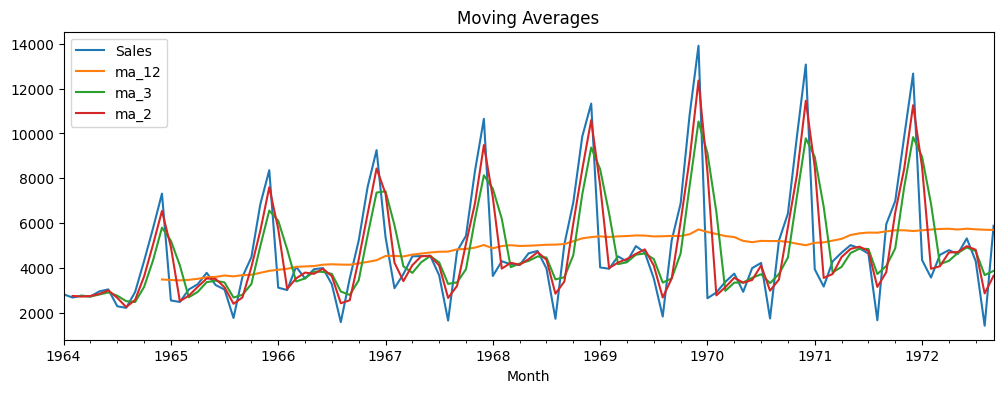

In [24]:
df["ma_12"] = df["Sales"].rolling(window=12).mean()
df["ma_3"]  = df["Sales"].rolling(window=3).mean()
df["ma_2"]  = df["Sales"].rolling(window=2).mean()

df[["Sales", "ma_12", "ma_3", "ma_2"]].plot(figsize=(12, 4), title="Moving Averages");

İstatistiksel olarak bir AR sürecini optimize eden üstel hareketli ortalama kullanarak daha güçlü bir yumuşatma tahmincisi de ekleyebilirsiniz (ipucu: 2, 3 ve 12 `halflife` ile `.ewm` metodu). Bu verileri çizin.

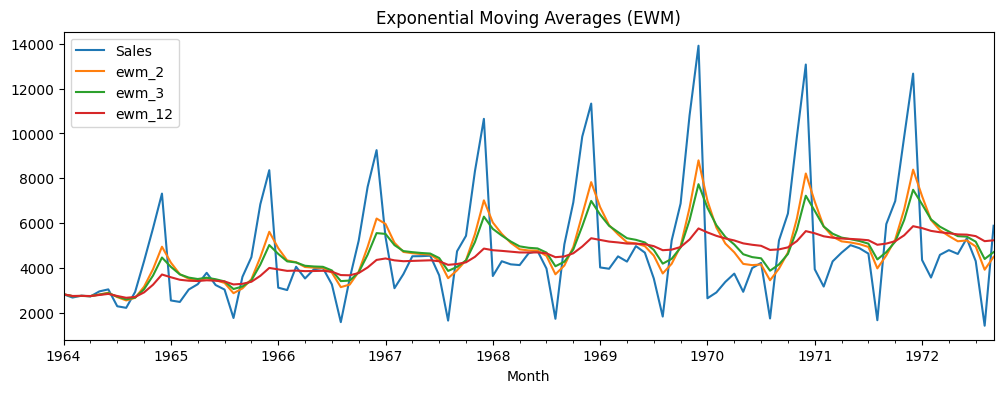

In [25]:
df["ewm_2"]  = df["Sales"].ewm(halflife=2).mean()
df["ewm_3"]  = df["Sales"].ewm(halflife=3).mean()
df["ewm_12"] = df["Sales"].ewm(halflife=12).mean()

df[["Sales", "ewm_2", "ewm_3", "ewm_12"]].plot(figsize=(12, 4), title="Exponential Moving Averages (EWM)");

Daha iyi bir MAPE görmelisiniz!

Her özelliğin önemine bakmayı deneyin. Ne buluyorsunuz?


In [26]:
# Yeni feature set: laglar + moving avg + ewm
feature_cols2 = [f"lag_{lag}" for lag in range(1, 13)] + ["ma_12", "ma_3", "ma_2", "ewm_2", "ewm_3", "ewm_12"]

ml_df2 = df[["Sales"] + feature_cols2].dropna().copy()

y2 = ml_df2["Sales"].values
X2 = ml_df2[feature_cols2].values
test_indexes2 = np.where(ml_df2.index >= pd.Timestamp("1970-01-01"))[0]

ground_truth2, predictions2, mape2 = evaluate_performance_month_prediction(
    y_true=y2,
    test_indexes=test_indexes2,
    predictor=rf,
    full_X=X2
)

print("RF (lags + MA + EWM) 1-step ahead MAPE:", mape2)

# Son fit ile feature importance
rf.fit(X2[:test_indexes2[0]], y2[:test_indexes2[0]])  # test başlangıcına kadar fit
importances = pd.Series(rf.feature_importances_, index=feature_cols2).sort_values(ascending=False)

importances.head(15)

RF (lags + MA + EWM) 1-step ahead MAPE: 0.15577878723780195


lag_12    0.812448
ma_2      0.055476
lag_11    0.014790
ewm_3     0.013693
ewm_2     0.013155
lag_2     0.010433
lag_6     0.009640
ma_3      0.009425
lag_8     0.008028
lag_10    0.007571
lag_1     0.007332
ewm_12    0.007162
ma_12     0.006801
lag_9     0.005977
lag_4     0.005260
dtype: float64

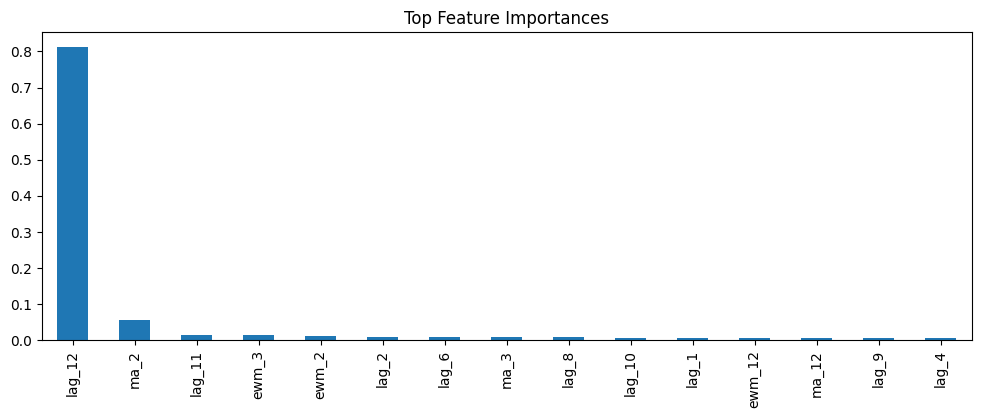

In [27]:
importances.head(15).plot(kind="bar", figsize=(12, 4), title="Top Feature Importances");

### Örneklem-Dışı Tahmin Modelleri

Şimdi "örneklem-dışı" tahminde SARIMA'yı geçmeyi deneyelim.

👉 _Her tahmin ufku için bir model eğitin_ (`1`-aylık ufuktan `len(y_test)` aya kadar)
👉 MAPE'yi değerlendirin ve SARIMA ile karşılaştırın

In [28]:
# SARIMA'nın test MAPE'si (referans)
sarima_mape = np.mean(
    np.abs(central.values - df_test.values) / np.abs(df_test.values)
)
print("SARIMA test MAPE:", sarima_mape)

# RF için horizon bazlı MAPE
horizon_mapes = []

# Hazırlık (geniş feature set)
y_all = ml_df2["Sales"].values
X_all = ml_df2[feature_cols2].values

# Test başlangıcı (1970-01)
test_start_idx = np.where(
    ml_df2.index >= pd.Timestamp("1970-01-01")
)[0][0]

test_len = len(df_test)
n_total = len(y_all)

for h in range(1, test_len + 1):
    preds = []
    gts = []

    # t + h < n_total olacak şekilde sınırla
    for t in range(test_start_idx, min(test_start_idx + test_len, n_total - h)):
        
        # Eğitim seti: sadece geçmiş
        X_train = X_all[:t]
        y_train = y_all[:t]

        # Tahmin edilecek nokta
        X_pred = X_all[t].reshape(1, -1)

        rf.fit(X_train, y_train)
        preds.append(rf.predict(X_pred)[0])
        gts.append(y_all[t + h])

    preds = np.array(preds)
    gts = np.array(gts)

    mape_h = np.mean(np.abs(preds - gts) / np.abs(gts))
    horizon_mapes.append(mape_h)

# Series olarak sakla
horizon_mapes = pd.Series(
    horizon_mapes,
    index=range(1, test_len + 1),
    name="RF MAPE"
)

horizon_mapes.head()

SARIMA test MAPE: 0.2941592365216924


/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gizemtotkanli/.pyenv/versions/3.12.9/envs/workintech_current/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1    0.467149
2    0.647299
3    0.700254
4    0.696280
5    0.662314
Name: RF MAPE, dtype: float64

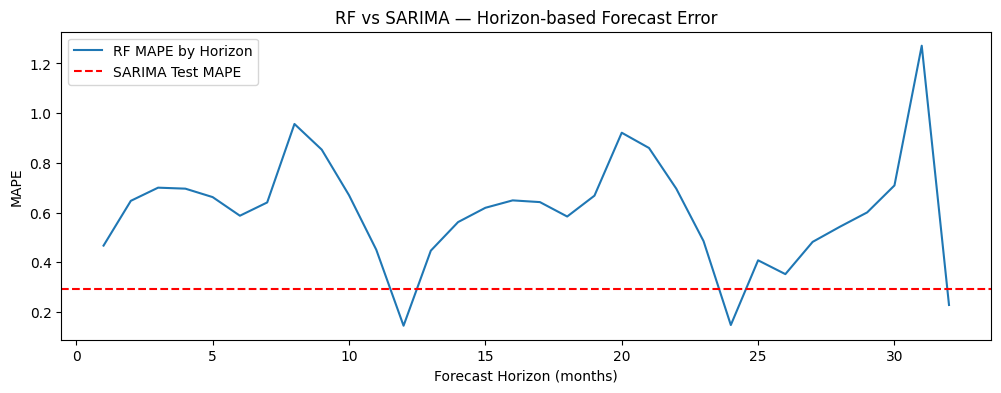

In [29]:
plt.figure(figsize=(12, 4))
horizon_mapes.plot(label="RF MAPE by Horizon")
plt.axhline(
    sarima_mape,
    linestyle="--",
    color="red",
    label="SARIMA Test MAPE"
)
plt.xlabel("Forecast Horizon (months)")
plt.ylabel("MAPE")
plt.title("RF vs SARIMA — Horizon-based Forecast Error")
plt.legend()
plt.show()